In [110]:
import os, sys
import pandas as pd
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Union
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from itertools import product
import scipy.stats as sps

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA

In [11]:
sys.path.insert(1, '../')

from source.risk_factors import ArimaFactors

In [16]:
all_data = pd.read_csv('../data/all_data.csv').set_index('date')

# Lets check

In [218]:
cur_date = pd.Timestamp('2023-01-01')
data = all_data.loc[all_data.index <= str(cur_date.date())][factor_list]

factor_list = ['brent', 'aluminum', 'usd_rub']

hist_corr = data.corr()

In [219]:
arimas = ArimaFactors(
    current_date=cur_date,
    data = data
)

arimas.fit()

In [204]:
from importlib import reload
from source import simulation_utils
reload(simulation_utils);

# 1 step


На первом шаге можем в принципе семплировать из многомерного нормального, раз все модели Гауссовские


Как формируем матрицу ковариаций? 

1. В качестве диагонали матрицы берем оценки дисперсий на нужном шаге из моделей,
2. Ковариация i с j: исторические корреляция i и j из обучающей выборки * std i * std j из шага 1


см. `simulation_utils.calculate_posterior_cov`

In [227]:
one_step_means = []
one_step_var = []

for name in factor_list:

    pred = arimas.models[name].get_forecast(steps=1)

    one_step_means.append(pred.predicted_mean.values[0])
    one_step_var.append(pred.var_pred_mean.values[0])

In [231]:
# выборка из совместного нормального на шаге 1

sample = simulation_utils.sample_multivariate_normal(
    factor_list=factor_list,
    prior_corr=hist_corr,
    est_mean=one_step_means,
    est_var=one_step_var, size=5000        
)

sample.mean(axis=0)

array([  85.88133092, 2376.80077962,   72.03841151])

In [232]:
all_data[factor_list].loc[all_data.index >= str(cur_date)].head(2)

,brent,aluminum,usd_rub
date,,,
2023-01-02,85.91,2378.0,71.9778
2023-01-03,85.91,2378.0,71.9778


# N steps 

Будем на каждом шаге симуляций траекторий факторов брать оценки дисперсий прогнозов и оценивать, насколько адекватно симуляция вписывается в распределение ожидаемых от моделей прогнозов с учетом корреляций 

Для примера

In [223]:
dist = sps.multivariate_normal(
    mean=[0, 0],
    cov=np.array([[1, 0.5], [0.5, 1]]),
)

In [224]:
dist.pdf([1, 1])

0.09435389770895924

In [226]:
dist.pdf([1, -1])

0.024871417406145683

То есть, если факторы скоррелированы, то за разнонаправленные относительно корреляции отклонения от среднего, наш лосс будет "наказывать" сильнее, чем за равные по модулю сонаправленные

Потестим фукцию для "вероятности" траектории

In [233]:
steps = 5
mean_series, var_series = arimas.forecast(steps)

In [235]:
simulations = arimas.simulate(steps)

Получили траектории трех факторов на 5 шагах

In [236]:
simulation_utils.calculate_simulation_probability(
    factor_list=factor_list,
    series_list=simulations,
    prior_corr=hist_corr,
    est_var=var_series,
    est_mean=mean_series,
    logging=False,
    logreturn=True
)

-79.56693496365442

Предложенный фильтр: 

Мы не можем использовать полученные от `simulation_utils.calculate_simulation_probability`, как полноценные вероятности, но при этом, можем использовать как некоторую меру, лосс

Т. к. quantile не веротяностная характеристика, а скорее уже гиперпараметр, его нужно по-хорошему отдельно калибровать

In [237]:
import inspect
print(inspect.getsource(simulation_utils.simulated_series_selection))

def simulated_series_selection(
    factor_list: list,
    simulations: List[List[np.array]], # M iterations for N days for K factors
    prior_cov: pd.DataFrame,
    est_var: List[np.array],
    est_mean: List[np.array],
    threshold=None,
    quantile=0.05,
):
    """
    Drops <quantile>% less likely simulations depending
    """
    
    NUM_SIM = len(simulations)
    probs = [0] * NUM_SIM
    
    for sim in range(NUM_SIM):
        
        probs[sim] = calculate_simulation_probability(
            factor_list,
            simulations[sim],
            prior_cov,
            est_var,
            est_mean,
            logging=False,
            logreturn=True
        )

    threshold = np.quantile(probs, quantile)
    
    for sim in range(NUM_SIM):
        if probs[sim] >= threshold:
            yield simulations[sim]



Посмотрим на симуляцих наших моделей

In [274]:
n_sim = 1000
n_steps = 10

simulations_list = [
    arimas.simulate(n_steps) for _ in range(n_sim)
]

means, vars = arimas.forecast(n_steps)


prob_loss = [
    simulation_utils.calculate_simulation_probability(
        factor_list=factor_list,
        series_list=i,
        prior_corr=hist_corr,
        est_var=vars,
        est_mean=means,
        logging=False,
        logreturn=True
    ) for i in simulations_list
]

In [275]:
sorted_sims = list(
    sorted(
        zip(
            prob_loss,
            simulations_list
        ),
        key=lambda x: x[0]
    )
)

In [276]:
# отскалируем данные чтобы их было можно отрисовать
scaler = StandardScaler().fit(data)

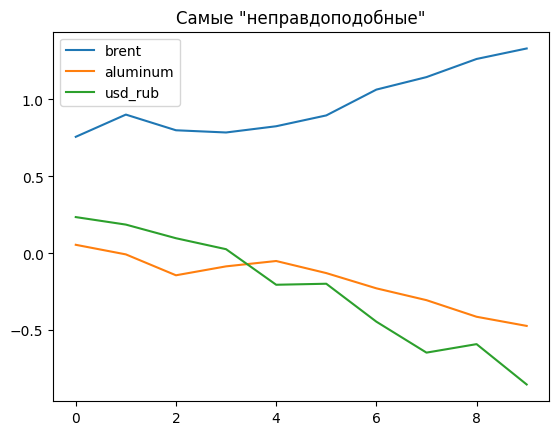

In [281]:
import matplotlib.pyplot as plt


to_plot = pd.DataFrame(scaler.transform(np.array(sorted_sims[0][1]).T), columns=factor_list)
to_plot.plot();
plt.title('Самые "неправдоподобные"');

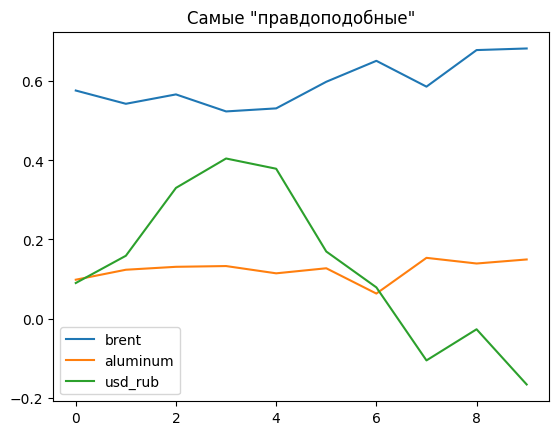

In [283]:
import matplotlib.pyplot as plt


to_plot = pd.DataFrame(scaler.transform(np.array(sorted_sims[-1][1]).T), columns=factor_list)
to_plot.plot();
plt.title('Самые "правдоподобные"');

In [284]:
hist_corr

,brent,aluminum,usd_rub
brent,1.000000,0.820272,-0.350326
aluminum,0.820272,1.000000,0.155451
usd_rub,-0.350326,0.155451,1.000000


Вот на этом примере +/- можно проследить нашу логику: цены алюминий и нефть по нашим историческим данным сильно скоррелированы

Поэтому сценарий где они расходятся в противоположных направлениях рассматривается как менее вероятный